## Train Reacher Notebook

The essential steps to this are:

* Define Unity environment
* Get the default brain
* Import DDPG Actor-Critic Framework
* Run DDPG training loop with default brain

In [ ]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agents
import torch
from collections import deque
import matplotlib.pyplot as plt

In [ ]:
env = UnityEnvironment(file_name="Reacher_Linux_NoVis/Reacher.x86_64", worker_id=7)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of each action
action_size = brain.vector_action_space_size

# size of each observation
states = env_info.vector_observations
state_size = states.shape[1]

# Initialise Agents
agent = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=1234)

In [ ]:
print(f'Number of agents: {num_agents}')
print(f'Action size: {action_size}')
print(f'State size: {state_size}')

Number of agents: 20
Action size: 4
State size: 33


In [ ]:
## Training function for DDPG
import os
try:
    os.makedirs('checkpoints')
except:
    pass

def ddpg(n_episodes=2000, max_t=1000, print_every=10, min_score=30.0):
    """DDPG Learning via Actor-Critic
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        min_score (float): the minimum score needed over the most recent 100 episodes to pass the environment
    """
    scores_episode = []                # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()                                          # resetting the noise process

        for t in range(max_t):
            actions = agent.act(states)                        # decide on the action
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to the environment

            next_states = env_info.vector_observations           # get next state (for each agent)
            rewards = np.array(env_info.rewards)                 # get reward (for each agent)
            dones = np.array(env_info.local_done, dtype=np.bool) # see if episode finished

            # Perform the learning step
            agent.step(states, actions, rewards, next_states, dones)
            
            scores += np.array(env_info.rewards)               # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break

        scores_window.append(np.mean(scores))               # save most recent averaged scores over the agents
        scores_episode.append(np.mean(scores))              # save most recent averaged scores over the agents

        print('\rEpisode {}\t# of timesteps needed: {}\tAverage Score: {:.2f}'.format(i_episode, t + 1, np.mean(scores_window)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\t# of timesteps needed: {}\tAverage Score: {:.2f}'.format(i_episode, t + 1, np.mean(scores_window)))
        if np.mean(scores_window) >= min_score:  # To deem this a success, we must achieve an average score of 30 in a 100 episode window
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), os.path.join('checkpoints', 'checkpoint_actor.pth'))
            torch.save(agent.critic_local.state_dict(), os.path.join('checkpoints', 'checkpoint_critic.pth'))
            break
    
    # If we don't converge, save it anyway
    if np.mean(scores_window) < min_score:
        print(f'Note: DDPG Agent did not solve after {n_episodes} episodes')
        torch.save(agent.actor_local.state_dict(), os.path.join('checkpoints', 'checkpoint_actor.pth'))
        torch.save(agent.critic_local.state_dict(), os.path.join('checkpoints', 'checkpoint_critic.pth'))

    return scores_episode

In [ ]:
scores = ddpg()

Episode 10	# of timesteps needed: 1000	Average Score: 0.73
Episode 20	# of timesteps needed: 1000	Average Score: 1.61
Episode 30	# of timesteps needed: 1000	Average Score: 2.77
Episode 40	# of timesteps needed: 1000	Average Score: 3.70
Episode 50	# of timesteps needed: 1000	Average Score: 5.35
Episode 60	# of timesteps needed: 1000	Average Score: 8.03
Episode 70	# of timesteps needed: 1000	Average Score: 10.85
Episode 80	# of timesteps needed: 1000	Average Score: 13.36
Episode 90	# of timesteps needed: 1000	Average Score: 15.34
Episode 100	# of timesteps needed: 1000	Average Score: 16.96
Episode 110	# of timesteps needed: 1000	Average Score: 20.24
Episode 120	# of timesteps needed: 1000	Average Score: 23.38
Episode 130	# of timesteps needed: 1000	Average Score: 26.43
Episode 140	# of timesteps needed: 1000	Average Score: 29.26
Episode 144	# of timesteps needed: 1000	Average Score: 30.03
Environment solved in 44 episodes!	Average Score: 30.03


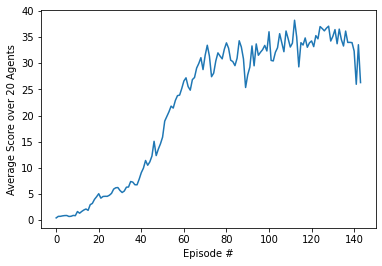

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Average Score over 20 Agents')
plt.xlabel('Episode #')
plt.show()